# Import Necessary Libraries

In [4]:
!pip install keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.3 MB/s eta 0:00:00


In [6]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras import layers

# System libraries
from pathlib import Path
import os.path
import random

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns

sns.set_style('darkgrid')

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Create helper functions

In [7]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2025-07-21 11:00:44--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2025-07-21 11:00:45 (18.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# Load and Transform Data

In [8]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [9]:
# Walk through each directory
dataset = "/kaggle/input/coco-nuts/data/data"
walk_through_dir(dataset);

There are 3 directories and 0 images in '/kaggle/input/coco-nuts/data/data'.
There are 0 directories and 1688 images in '/kaggle/input/coco-nuts/data/data/malauhog'.
There are 0 directories and 1610 images in '/kaggle/input/coco-nuts/data/data/malakanin'.
There are 0 directories and 1205 images in '/kaggle/input/coco-nuts/data/data/malakatad'.


# Placing Data into a Dataframe

In [10]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

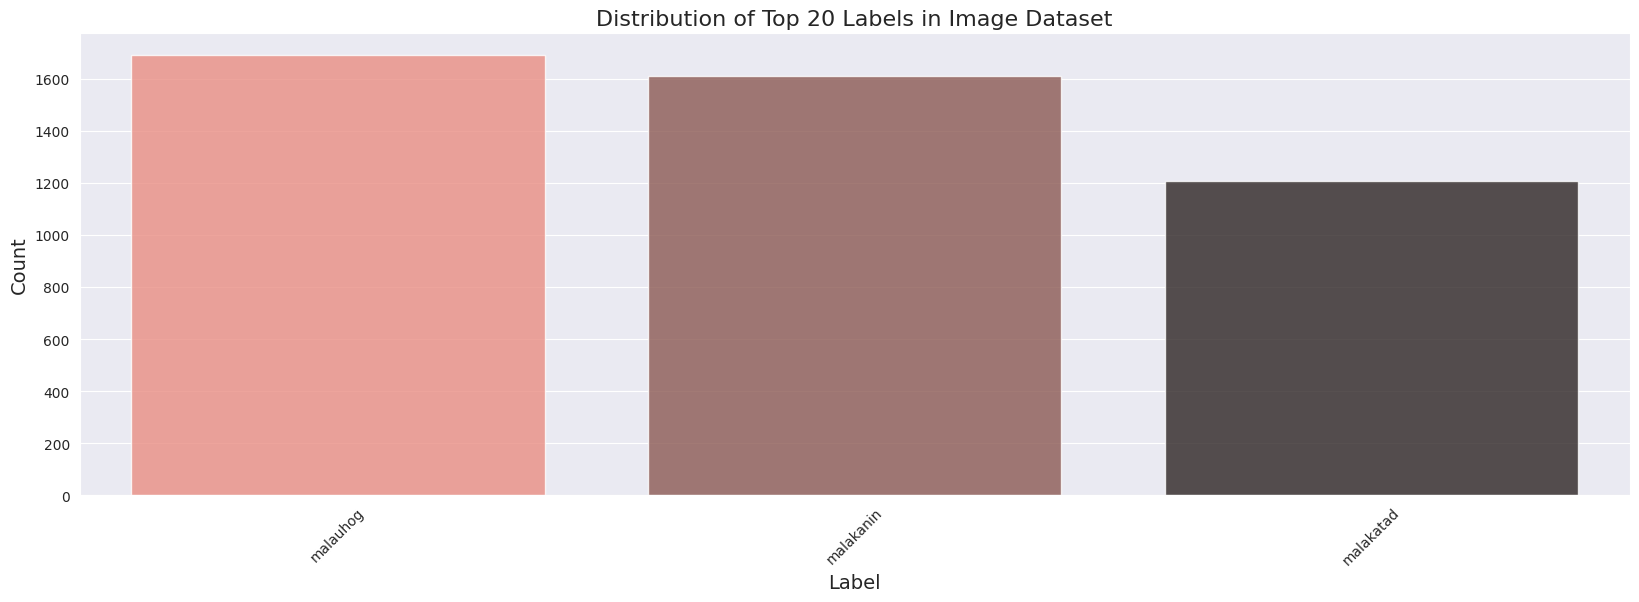

In [11]:
# Get the top 20 labels
label_counts = image_df['Label'].value_counts()[:20]

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')
plt.title('Distribution of Top 20 Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

# Visualizing images from the dataset

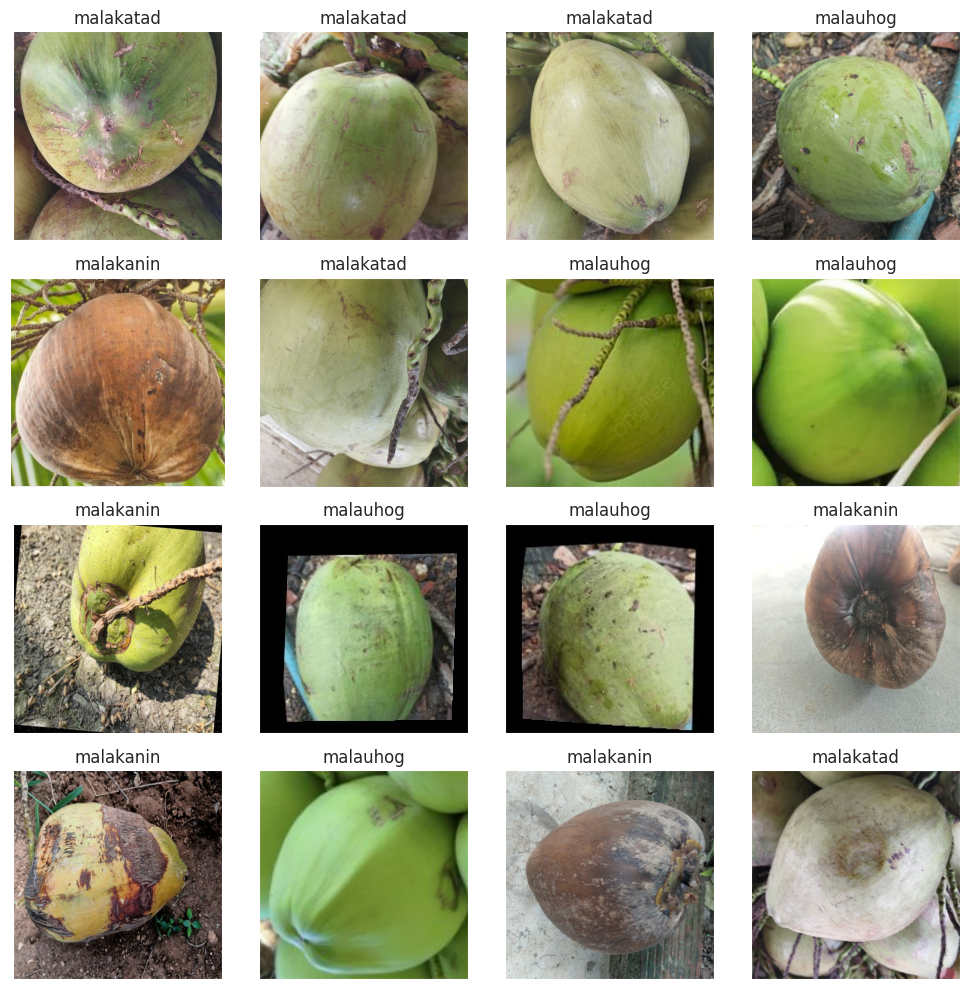

In [12]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# Computing Error Rate Analysis

In [13]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

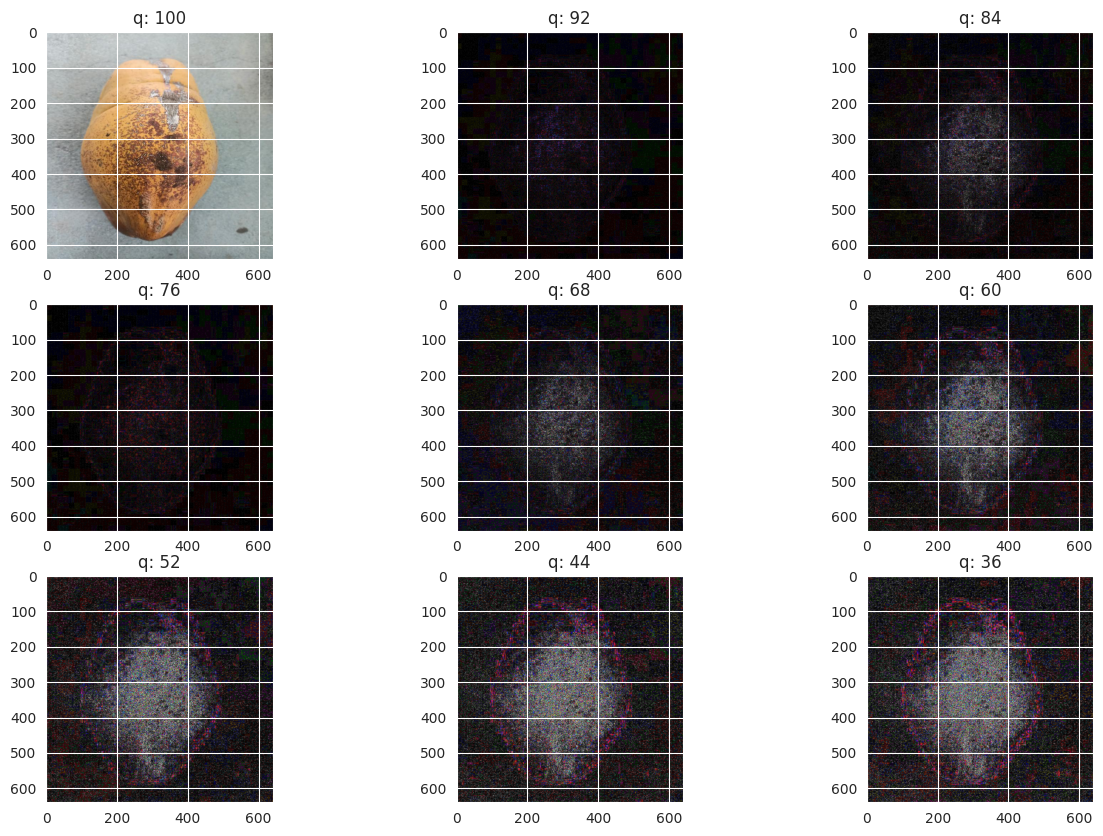

In [14]:
# View random sample from the dataset
p = random_sample('/kaggle/input/coco-nuts/data/data/malakanin')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

# Data Preprocessing

In [15]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)


In [16]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [17]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 2883 validated image filenames belonging to 3 classes.
Found 720 validated image filenames belonging to 3 classes.
Found 901 validated image filenames belonging to 3 classes.


In [20]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.Resizing(224,224),
  layers.Rescaling(1./255),
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.RandomContrast(0.1),
])

I0000 00:00:1753096006.876326      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


# Training the model

In [21]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
# Create checkpoint callback
checkpoint_path = "coconut_classification_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

> **Training the model**

In [26]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=150,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "coconut_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/coconut_classification/20250721-111212
Epoch 1/150


I0000 00:00:1753096350.996990     120 service.cc:148] XLA service 0x7f79a92999d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753096350.997778     120 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753096352.941860     120 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753096362.818139     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.4082 - loss: 1.9166

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


91/91 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.4092 - loss: 1.9109 - val_accuracy: 0.7972 - val_loss: 0.5228 - learning_rate: 1.0000e-04
Epoch 2/150
91/91 ━━━━━━━━━━━━━━━━━━━━ 52s 569ms/step - accuracy: 0.6619 - loss: 0.7642 - val_accuracy: 0.9097 - val_loss: 0.3551 - learning_rate: 1.0000e-04
Epoch 3/150
91/91 ━━━━━━━━━━━━━━━━━━━━ 52s 571ms/step - accuracy: 0.7818 - loss: 0.5431 - val_accuracy: 0.9236 - val_loss: 0.2614 - learning_rate: 1.0000e-04
Epoch 4/150
91/91 ━━━━━━━━━━━━━━━━━━━━ 54s 593ms/step - accuracy: 0.8565 - loss: 0.4005 - val_accuracy: 0.9458 - val_loss: 0.1823 - learning_rate: 1.0000e-04
Epoch 5/150
91/91 ━━━━━━━━━━━━━━━━━━━━ 51s 555ms/step - accuracy: 0.8830 - loss: 0.3309 - val_accuracy: 0.9431 - val_loss: 0.1648 - learning_rate: 1.0000e-04
Epoch 6/150
91/91 ━━━━━━━━━━━━━━━━━━━━ 51s 560ms/step - accuracy: 0.8952 - loss: 0.2710 - val_accuracy: 0.9528 - val_loss: 0.1324 - learning_rate: 1.0000e-04
Epoch 7/150
91/91 ━━━━━━━━━━━━━━━━━━━━ 51s 561ms/step - accuracy: 

# Model Evaluation

In [27]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.05623
Test Accuracy: 98.56%


# Visualizing loss curves

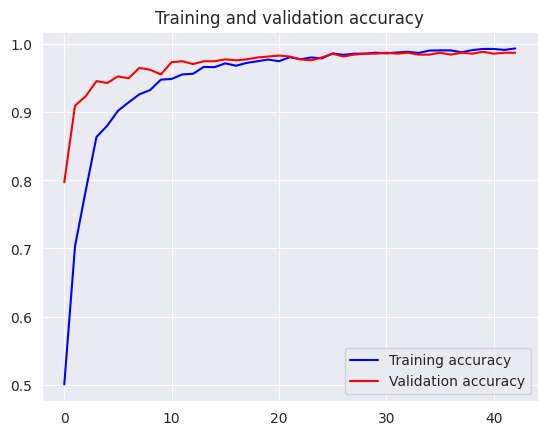

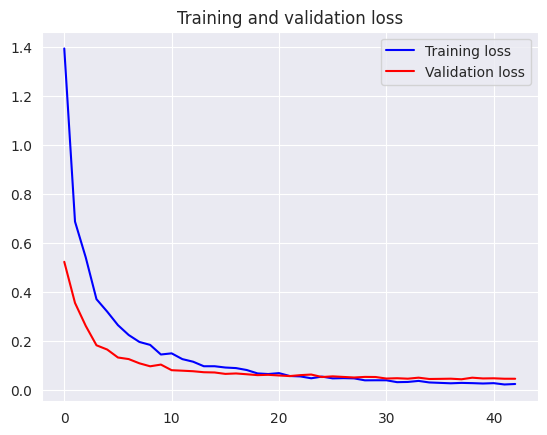

In [28]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

# Making predictions on the Test Data

In [29]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

29/29 ━━━━━━━━━━━━━━━━━━━━ 26s 660ms/step
The first 5 predictions: ['malakanin', 'malakanin', 'malakanin', 'malauhog', 'malakanin']


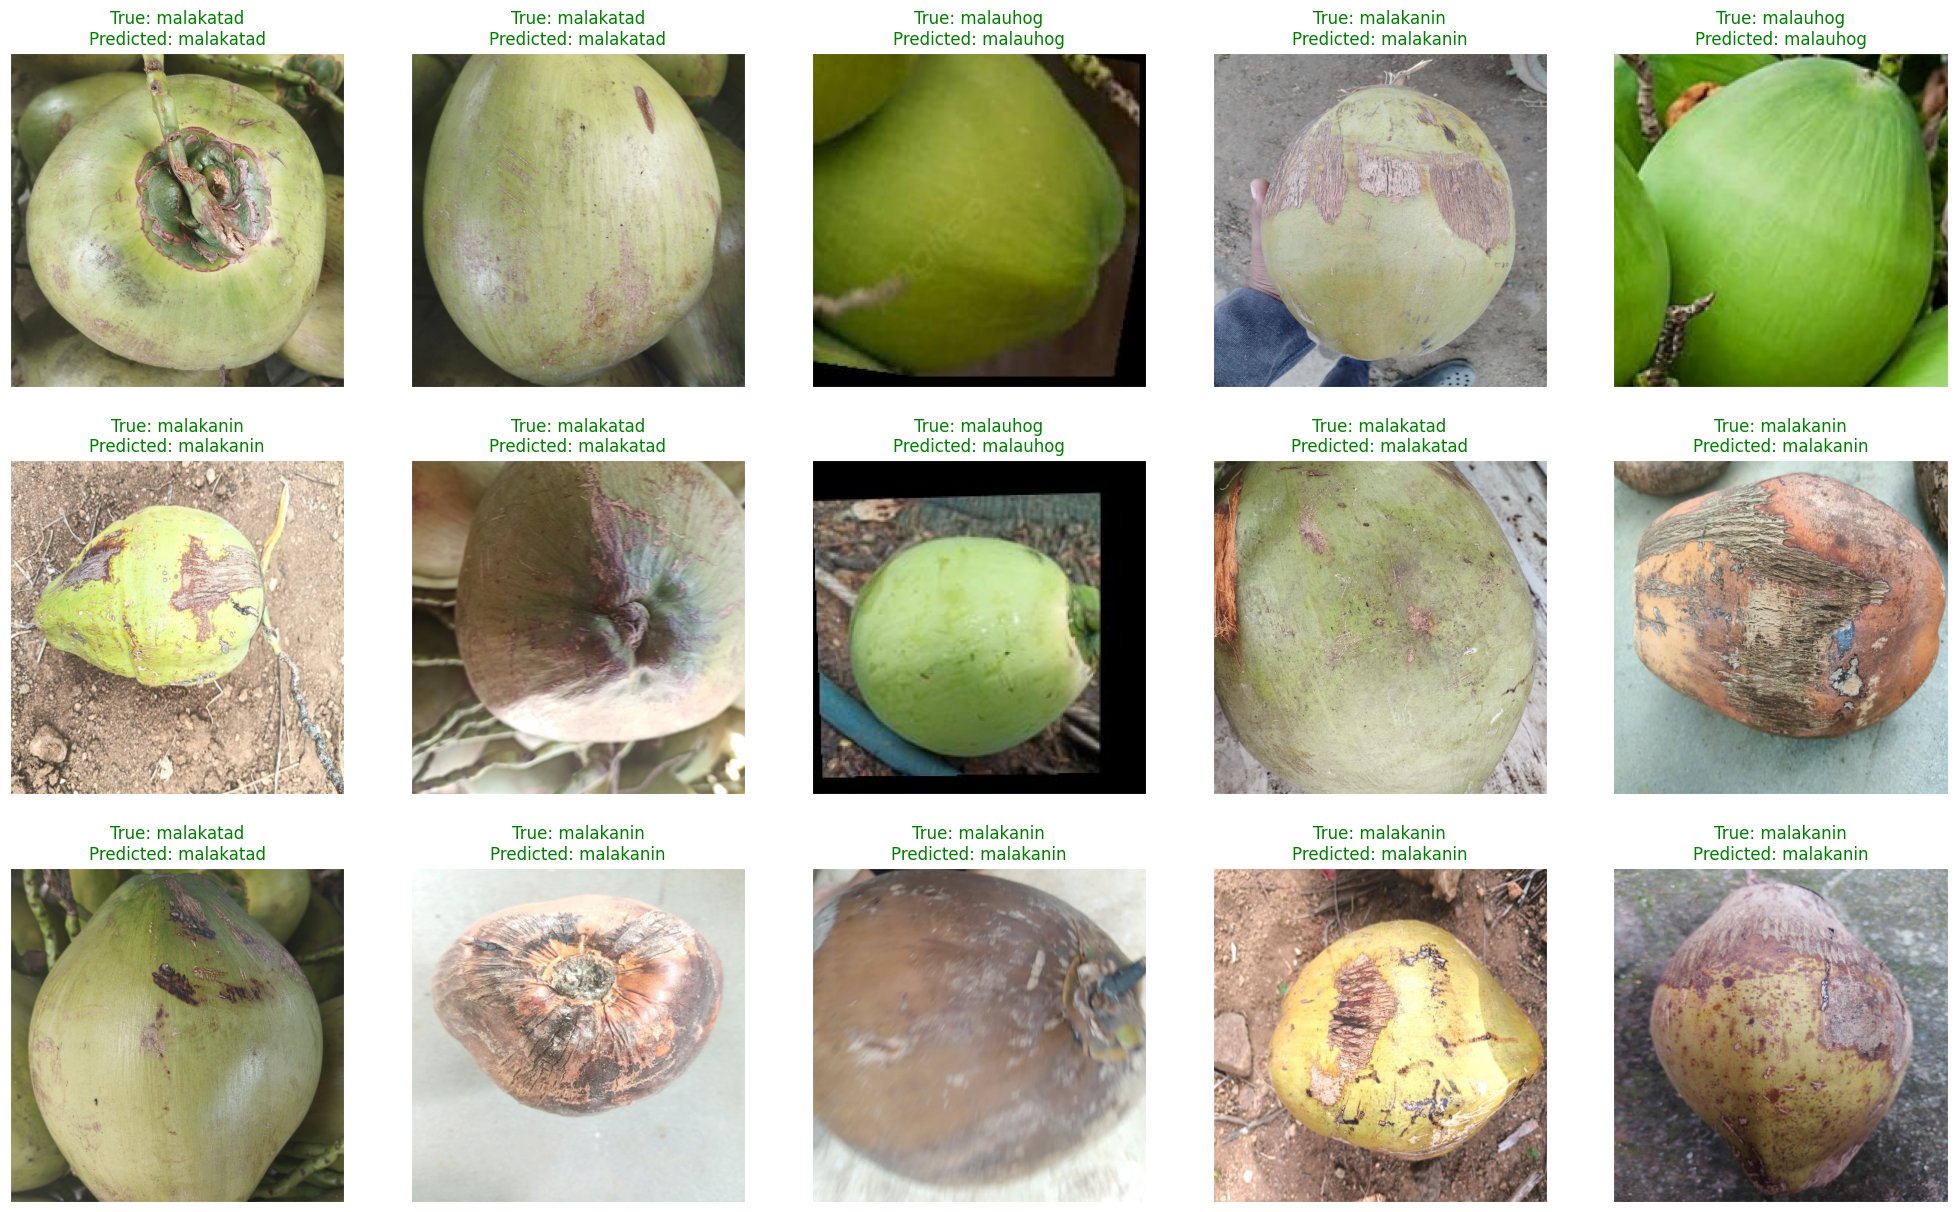

<Figure size 640x480 with 0 Axes>

In [30]:
 # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# Plotting the Classification Reports and Confusion Matrix

In [31]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

   malakanin       0.99      0.98      0.98       311
   malakatad       0.98      0.98      0.98       237
    malauhog       0.99      0.99      0.99       353

    accuracy                           0.99       901
   macro avg       0.98      0.99      0.99       901
weighted avg       0.99      0.99      0.99       901



In [32]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score     support
malakanin      0.987055  0.980707  0.983871  311.000000
malakatad      0.978992  0.983122  0.981053  237.000000
malauhog       0.988701  0.991501  0.990099  353.000000
accuracy       0.985572  0.985572  0.985572    0.985572
macro avg      0.984916  0.985110  0.985008  901.000000
weighted avg   0.985579  0.985572  0.985570  901.000000

#  Convert your trained model to .tflite

In [34]:
# Save the model
model.export("coconut_model")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("coconut_model")
tflite_model = converter.convert()

# Save the TFLite model
with open("coconut_model.tflite", "wb") as f:
    f.write(tflite_model)


Saved artifact at 'coconut_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140163439628304: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140163439630608: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140163506484240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140163506485008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140163506485584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140163506484816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140163506483856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140163506486352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140163506486160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140163499868624: TensorSpec(shape=(), dtype=tf.resource, name=None)
 

W0000 00:00:1753099550.066732      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1753099550.066791      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1753099550.265273      35 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


In [41]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="coconut_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input shape:", input_details[0]['shape'])  # (1, 224, 224, 3)


Input shape: [  1 224 224   3]


In [50]:
def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((224, 224))
    img_array = np.array(img, dtype=np.float32) # Normalize to [0,1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array


In [56]:
# Preprocess image
input_data = preprocess_image("/kaggle/input/coco-nuts/1.jpg")

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference
interpreter.invoke()

# Get predictions
output_data = interpreter.get_tensor(output_details[0]['index'])
print("Predictions:", output_data)
print("Predicted class index:", np.argmax(output_data))


Predictions: [[9.9799961e-01 1.3719798e-06 1.9989070e-03]]
Predicted class index: 0
